# RNN을 이용한 시계열 데이터 예측
- 주식가격과 같은 시계열(time series) 데이터를 예측하는 RNN 모델을 구현해 보도록 하자.(대게 many_to_many(sequence2sequence)임)

## 가상의 시계열 데이터 만들기

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

In [4]:
# mini-batch function
def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

In [5]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

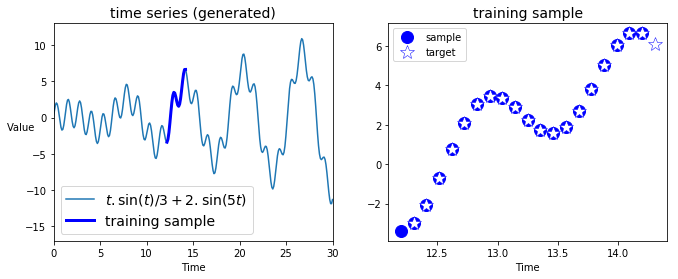

In [7]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="training sample")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value", rotation=0)

plt.subplot(122)
plt.title("training sample", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=12, label="sample")
plt.plot(t_instance[1:], time_series(t_instance[1:]), 
         "w*", markeredgewidth=0.5, markeredgecolor="b", markersize=14, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## RNN for Time Series

- 각 타임 스텝마다 (batch_size, n_neurons) 출력 벡터를 tf.reshape()을 이용해 쌓는다(stack).
- 그런 다음, 1개의 유닛을 가지는 Fully-Connected Layer를 적용한다. 이때의 FC Layer는 단지 차원 축소를 위한 레이어이기 때문에 활성화 함수를 사용하지 않는다.
- 마지막으로, tf.reshape()을 이용해 차원 축소시킨 출력을 다시 타임 스텝별로 풀어준다(unstack).

In [9]:
################
# Layer Params #
################
n_steps = 20
n_neurons = 100
n_inputs = 1
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [10]:
# RNN Model
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

# 하나의 출력을 위한 작업
stacked_rnn_outputs = tf.reshape(tensor=rnn_outputs, shape=[-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
predictions = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.dense instead.


In [11]:
################
# Train Params #
################
learning_rate = 0.001
n_iterations = 600
batch_size = 50

In [12]:
# loss
mse = tf.losses.mean_squared_error(labels=y, predictions=predictions)
# optimizer
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(mse)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
# Train
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for iteration in range(n_iterations):
        batch_x, batch_y = next_batch(batch_size, n_steps)
        sess.run(train_op, feed_dict={X: batch_x, y: batch_y})
        if iteration % 100 == 0:
            loss = mse.eval(feed_dict={X: batch_x, y: batch_y})
            print('step: {:03d}, MSE: {:.4f}'.format(iteration, loss))
            
    # 새로운 데이터 예측하기
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(predictions, feed_dict={X: X_new})
    
print('y_pred:{}\n{}'.format(y_pred.shape, y_pred))            

step: 000, MSE: 15.8014
step: 100, MSE: 0.4321
step: 200, MSE: 0.2042
step: 300, MSE: 0.1011
step: 400, MSE: 0.0691
step: 500, MSE: 0.0505
y_pred:(1, 20, 1)
[[[-3.4992046 ]
  [-2.5440252 ]
  [-1.1974427 ]
  [ 0.56381285]
  [ 2.2065334 ]
  [ 3.0826092 ]
  [ 3.5421464 ]
  [ 3.3491364 ]
  [ 2.7717054 ]
  [ 2.1865697 ]
  [ 1.7573457 ]
  [ 1.5112762 ]
  [ 1.8983567 ]
  [ 2.7320604 ]
  [ 3.9054427 ]
  [ 5.1240106 ]
  [ 6.1409917 ]
  [ 6.6385903 ]
  [ 6.595203  ]
  [ 5.976651  ]]]


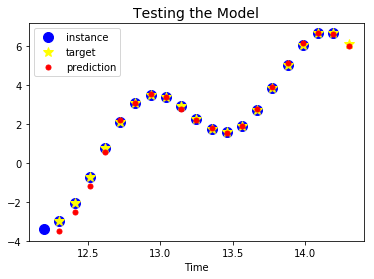

In [16]:
plt.title("Testing the Model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target", color='yellow')
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()